In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# Replace 'your-folder-path' with the actual path to your dataset in Google Drive
dataset_path = '/content/drive/My Drive/creditcard.csv'


In [ ]:
import pandas as pd

# Load the dataset
df_fraud = pd.read_csv(dataset_path)

# Display the first few rows to ensure it loaded correctly
df_fraud.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
# Filter relevant columns and preprocess
df_fraud = df_fraud[['Time', 'V1', 'V2', 'V3', 'Amount', 'Class']]
df_fraud.columns = ['Timestamp', 'Feature1', 'Feature2', 'Feature3', 'Amount', 'IsFraud']

# Sample a smaller dataset for the simulation
df_sample_fraud = df_fraud.sample(1000, random_state=42)
df_sample_fraud.reset_index(drop=True, inplace=True)

# Display the distribution to understand the imbalance
print(df_sample_fraud['IsFraud'].value_counts())

df_sample_fraud.head()


IsFraud
0    998
1      2
Name: count, dtype: int64


,Timestamp,Feature1,Feature2,Feature3,Amount,IsFraud
0,41505.0,-16.526507,8.584972,-18.649853,364.19,1
1,44261.0,0.339812,-2.743745,-0.134070,520.12,0
2,35484.0,1.399590,-0.590701,0.168619,31.00,0
3,167123.0,-0.432071,1.647895,-1.669361,1.50,0
4,168473.0,2.014160,-0.137394,-1.015839,0.89,0


In [ ]:
import hashlib
import time

class Block:
    def __init__(self, index, previous_hash, timestamp, data, nonce=0):
        self.index = index
        self.previous_hash = previous_hash
        self.timestamp = timestamp
        self.data = data
        self.nonce = nonce
        self.hash = self.calculate_hash()

    def calculate_hash(self):
        block_string = f"{self.index}{self.previous_hash}{self.timestamp}{self.data}{self.nonce}"
        return hashlib.sha256(block_string.encode()).hexdigest()

    def mine_block(self, difficulty):
        target = '0' * difficulty
        while self.hash[:difficulty] != target:
            self.nonce += 1
            self.hash = self.calculate_hash()

class Blockchain:
    def __init__(self):
        self.chain = [self.create_genesis_block()]
        self.difficulty = 4

    def create_genesis_block(self):
        return Block(0, "0", time.time(), "Genesis Block")

    def get_latest_block(self):
        return self.chain[-1]

    def add_block(self, new_block):
        new_block.previous_hash = self.get_latest_block().hash
        new_block.mine_block(self.difficulty)
        self.chain.append(new_block)

    def is_chain_valid(self):
        for i in range(1, len(self.chain)):
            current_block = self.chain[i]
            previous_block = self.chain[i-1]

            if current_block.hash != current_block.calculate_hash():
                return False
            if current_block.previous_hash != previous_block.hash:
                return False
        return True

class FinanceApp:
    def __init__(self):
        self.blockchain = Blockchain()

    def add_transaction(self, timestamp, feature1, feature2, feature3, amount, is_fraud):
        transaction = {
            "timestamp": timestamp,
            "feature1": feature1,
            "feature2": feature2,
            "feature3": feature3,
            "amount": amount,
            "is_fraud": is_fraud
        }
        self.blockchain.add_block(Block(len(self.blockchain.chain), "", transaction['timestamp'], transaction))
        print(f"Transaction added to the blockchain: Fraud = {is_fraud}")

    def display_chain(self):
        for block in self.blockchain.chain:
            print(f"Block {block.index}: {block.data} | Hash: {block.hash}")


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Initialize the finance app
app_fraud = FinanceApp()

# Limit the number of transactions to process (e.g., 100)
num_transactions = 100

# Add transactions to the blockchain
for i, row in df_sample_fraud.head(num_transactions).iterrows():
    app_fraud.add_transaction(row['Timestamp'], row['Feature1'], row['Feature2'], row['Feature3'], row['Amount'], row['IsFraud'])

# Display the blockchain (optional: comment out if output is too large)
# app_fraud.display_chain()

# Analyze the blockchain accuracy
y_true_fraud = [1 if block.data['is_fraud'] == 0 else 0 for block in app_fraud.blockchain.chain[1:]]  # True labels (1 if valid, 0 if tampered)
y_pred_fraud = [1 if block.hash == block.calculate_hash() else 0 for block in app_fraud.blockchain.chain[1:]]

# Calculate accuracy, precision, recall, and F1-score
accuracy_fraud = accuracy_score(y_true_fraud, y_pred_fraud)
precision_fraud = precision_score(y_true_fraud, y_pred_fraud)
recall_fraud = recall_score(y_true_fraud, y_pred_fraud)
f1_fraud = f1_score(y_true_fraud, y_pred_fraud)

# Display the results
print(f"Accuracy (Fraud Dataset): {accuracy_fraud:.2f}")
print(f"Precision (Fraud Dataset): {precision_fraud:.2f}")
print(f"Recall (Fraud Dataset): {recall_fraud:.2f}")
print(f"F1-Score (Fraud Dataset): {f1_fraud:.2f}")



Transaction added to the blockchain: Fraud = 1.0
Transaction added to the blockchain: Fraud = 0.0
Transaction added to the blockchain: Fraud = 0.0
Transaction added to the blockchain: Fraud = 0.0
Transaction added to the blockchain: Fraud = 0.0
Transaction added to the blockchain: Fraud = 0.0
Transaction added to the blockchain: Fraud = 0.0
Transaction added to the blockchain: Fraud = 0.0
Transaction added to the blockchain: Fraud = 0.0
Transaction added to the blockchain: Fraud = 0.0
Transaction added to the blockchain: Fraud = 0.0
Transaction added to the blockchain: Fraud = 0.0
Transaction added to the blockchain: Fraud = 0.0
Transaction added to the blockchain: Fraud = 0.0
Transaction added to the blockchain: Fraud = 0.0
Transaction added to the blockchain: Fraud = 0.0
Transaction added to the blockchain: Fraud = 0.0
Transaction added to the blockchain: Fraud = 0.0
Transaction added to the blockchain: Fraud = 0.0
Transaction added to the blockchain: Fraud = 0.0
Transaction added to

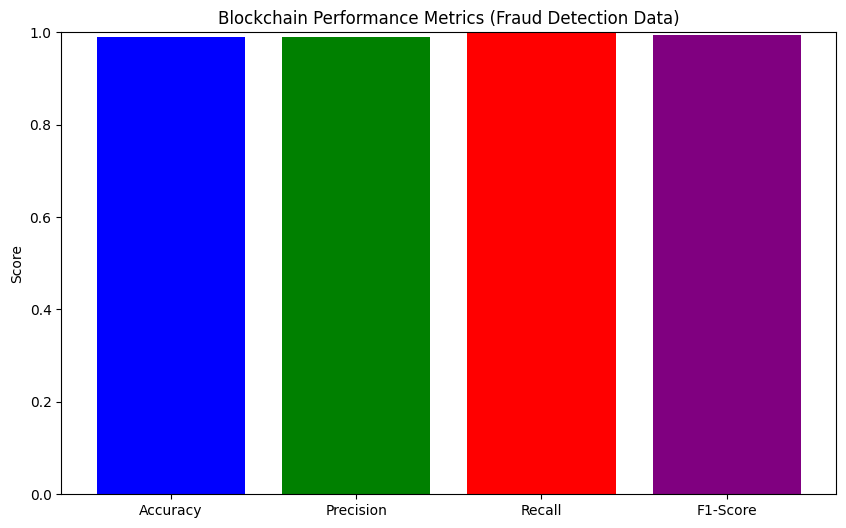

In [ ]:
import matplotlib.pyplot as plt

# Plot the metrics for the fraud dataset
metrics_fraud = ["Accuracy", "Precision", "Recall", "F1-Score"]
scores_fraud = [accuracy_fraud, precision_fraud, recall_fraud, f1_fraud]

plt.figure(figsize=(10, 6))
plt.bar(metrics_fraud, scores_fraud, color=['blue', 'green', 'red', 'purple'])
plt.ylim(0, 1)
plt.title('Blockchain Performance Metrics (Fraud Detection Data)')
plt.ylabel('Score')
plt.show()
